<a href="https://colab.research.google.com/github/brendarocha1/ser-347/blob/main/Fluxo_de_Processamento_Dissertacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Instalação de bibliotecas
!pip install spectral -q
!pip install rasterio -q
!pip install GDAL
!pip install matplotlib
!pip install scikit-learn

In [ ]:
# Importação de bibliotecas/métodos
from spectral import imshow
import tifffile as tif
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import random
import shutil
from osgeo import gdal, gdal_array
gdal.UseExceptions()
from rasterio.plot import reshape_as_image, reshape_as_raster
from sklearn.decomposition import PCA
from matplotlib.colors import hsv_to_rgb
from spectral import imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Leitura das imagens original
img_ori = tif.imread('/content/drive/MyDrive/ic_larissa/teste3/mux_caragua.tif')
img_ori.shape

(971, 792, 4)

In [ ]:
# Metadados
img_original_meta = rio.open('/content/drive/MyDrive/ic_larissa/teste3/mux_caragua.tif')
meta = img_original_meta.profile
meta

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 792, 'height': 971, 'count': 4, 'crs': CRS.from_epsg(32723), 'transform': Affine(16.0, 0.0, 445584.0,
       0.0, -16.0, 7390160.0), 'blockysize': 2, 'tiled': False, 'interleave': 'pixel'}

In [ ]:
# Obtenção de dados estatísticos
l_min = [img_ori[:,:,i].min() for i in range(img_ori.shape[2])]
l_per = [np.percentile(img_ori[:,:,i], 1) for i in range(img_ori.shape[2])]
print("Valores mínimos por banda:", l_min)
print("Percentis 1 por banda:", l_per)

# Criando uma lista com os nomes das bandas corrigidas
l_arquivo = ['img_corrigida' + str(i + 1) for i in range(img_ori.shape[2])]

# Correção das bandas
for i in range(img_ori.shape[2]):
    l_arquivo[i] = np.where((img_ori[:,:,i] - l_per[i]) > 0, img_ori[:,:,i] - l_per[i], 1)

# Empilhamento das bandas espectrais
stack_img_corr = np.dstack(l_arquivo)
print("Imagem empilhada:")
print(stack_img_corr)


Valores mínimos por banda: [54, 41, 27, 47]
Percentis 1 por banda: [58.0, 45.0, 30.0, 54.0]
Imagem empilhada:
[[[ 1.  1.  1. 44.]
  [ 1.  1.  1. 46.]
  [ 1.  1.  1. 46.]
  ...
  [ 9.  8.  7. 41.]
  [ 9.  7.  7. 39.]
  [ 9.  8.  7. 38.]]

 [[ 1.  1.  1. 45.]
  [ 1.  1.  1. 44.]
  [ 1.  1.  1. 44.]
  ...
  [ 9.  8.  7. 40.]
  [ 9.  7.  8. 40.]
  [ 9.  8.  7. 37.]]

 [[ 1.  1.  1. 44.]
  [ 1.  1.  1. 43.]
  [ 1.  1.  1. 43.]
  ...
  [ 9.  8.  7. 42.]
  [10.  8.  8. 44.]
  [ 9.  9.  8. 41.]]

 ...

 [[30. 26. 25. 42.]
  [29. 26. 24. 42.]
  [29. 26. 23. 41.]
  ...
  [26. 23. 19. 58.]
  [25. 23. 20. 58.]
  [27. 24. 20. 57.]]

 [[30. 27. 24. 43.]
  [29. 26. 23. 42.]
  [30. 26. 23. 40.]
  ...
  [25. 23. 19. 53.]
  [26. 23. 19. 53.]
  [27. 23. 19. 56.]]

 [[31. 27. 25. 44.]
  [29. 26. 24. 42.]
  [30. 25. 23. 39.]
  ...
  [26. 23. 19. 53.]
  [26. 23. 19. 53.]
  [26. 22. 19. 57.]]]


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Display bands       :  (2, 1, 0)
  Interpolation       :  <default>
  RGB data limits     :
    R: [27.0, 130.0]
    G: [41.0, 148.0]
    B: [54.0, 169.0]

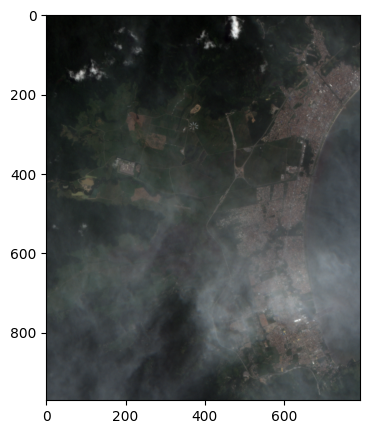

In [ ]:
# Visualização de uma composição colorida da imagem original
imshow(img_ori, (2,1,0), figsize=(8,5))

ImageView object:
  Display bands       :  (2, 1, 0)
  Interpolation       :  <default>
  RGB data limits     :
    R: [1.0, 100.0]
    G: [1.0, 103.0]
    B: [1.0, 111.0]

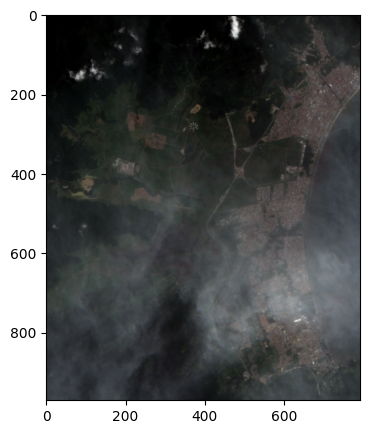

In [ ]:
# Visualização de uma composição colorida da imagem corrigida
imshow(stack_img_corr, (2,1,0), figsize=(8,5))

Text(0.5, 1.0, 'Imagem corrigida WPM/CBERS-4A')

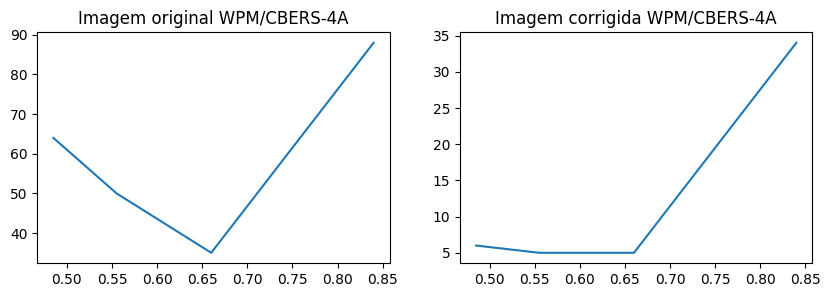

In [ ]:
plt.rcParams['figure.figsize'] = (10,3)
x= 0.485, 0.555, 0.66, 0.84
fig, ax= plt.subplots(1,2)
ax[0].plot(x, img_ori [261, 426,:])
ax[0].set_title('Imagem original WPM/CBERS-4A')
ax[1].plot(x, stack_img_corr [261, 426,:])
ax[1].set_title('Imagem corrigida WPM/CBERS-4A')

In [ ]:
# Voltando para o formato bandas x linhas x colunas
stack_WPM = stack_img_corr.swapaxes(2,1)
stack_WPM = stack_WPM.swapaxes(1,0)
stack_WPM.shape

(4, 971, 792)

In [ ]:
# Gravação da imagem corrigida em disco
#with rio.open('sao_sebastiao_corrigida_brenda.tiff', 'w', **meta) as src:
  #src.write(stack_WPM)

<ipython-input-29-0809865fda40>:18: RuntimeWarning: divide by zero encountered in divide
  evi = G * ((nir_band - red_band) / (nir_band + C1 * red_band - C2 * blue_band + L))
<ipython-input-29-0809865fda40>:18: RuntimeWarning: invalid value encountered in divide
  evi = G * ((nir_band - red_band) / (nir_band + C1 * red_band - C2 * blue_band + L))


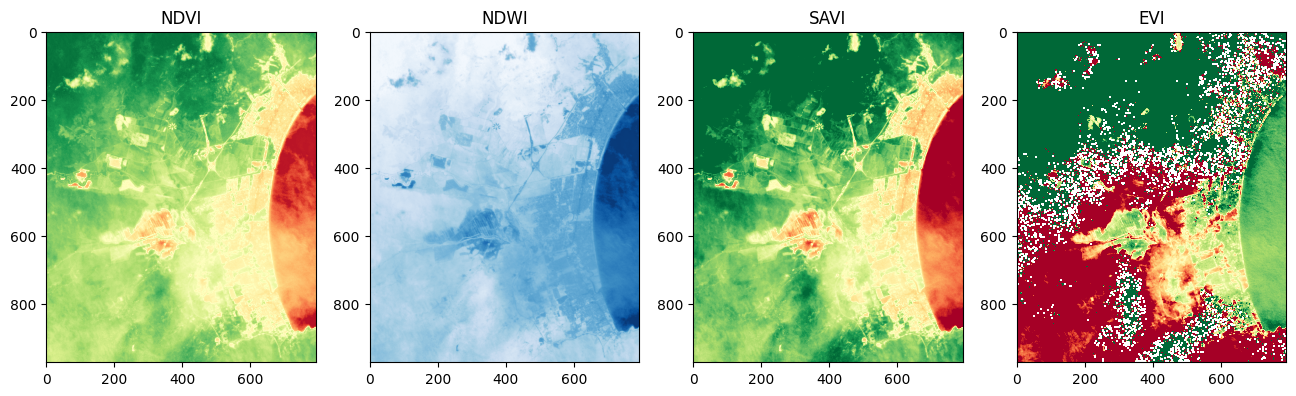

In [ ]:
# Calcular índices espectrais a partir das bandas corrigidas
blue_band = stack_WPM[0] # BLUE
green_band = stack_WPM[1] # GREEN
red_band = stack_WPM[2]  # Red
nir_band = stack_WPM[3]  # NIR

# NDVI (Normalized Difference Vegetation Index)
ndvi = (nir_band - red_band) / (nir_band + red_band)

# SAVI (Soil Adjusted Vegetation Index)
L = 0.5  # Fator de ajuste do solo, pode ser alterado conforme necessário
savi = ((1 + L) * (nir_band - red_band)) / (nir_band + red_band + L)

# EVI (Enhanced Vegetation Index)
G = 2.5  # Ganho, pode ser alterado conforme necessário
C1 = 6.0  # Coeficiente do termo do canope, pode ser alterado conforme necessário
C2 = 7.5  # Coeficiente do termo do solo, pode ser alterado conforme necessário
evi = G * ((nir_band - red_band) / (nir_band + C1 * red_band - C2 * blue_band + L))

# NDWI (Normalized Difference Water Index)
ndwi = (green_band - nir_band) / (green_band + nir_band)

# Visualizar os índices espectrais
plt.figure(figsize=(16, 10))
plt.subplot(141)
plt.title("NDVI")
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1.0, vmax=1.0);
plt.subplot(143)
plt.title("SAVI")
plt.imshow(savi, cmap='RdYlGn', vmin=-1.0, vmax=1.0);
plt.subplot(144)
plt.title("EVI")
plt.imshow(evi, cmap='RdYlGn', vmin=-1.0, vmax=1.0);
plt.subplot(142)
plt.title("NDWI")
plt.imshow(ndwi, cmap='Blues', vmin=-1.0, vmax=1.0);

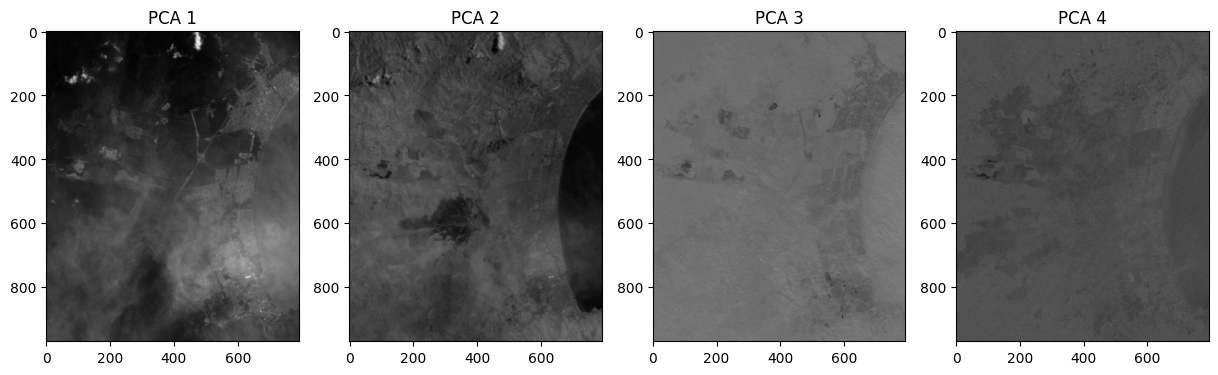

In [ ]:
# Implementação da PCA
# Preparar os dados para a PCA (reshape das bandas corrigidas)
num_bandas, num_linhas, num_colunas = stack_WPM.shape
bandas_reshaped = stack_WPM.reshape(num_bandas, num_linhas * num_colunas).T

# Realizar a PCA
pca = PCA(n_components=4)  # Definir o número de componentes principais desejado (neste caso, 3)
bandas_pca = pca.fit_transform(bandas_reshaped)

# Reverter o reshape para a forma original
bandas_pca = bandas_pca.T.reshape(4, num_linhas, num_colunas)

#Dividir as Pcas
cp1 = bandas_pca[0]
cp2 = bandas_pca[1]
cp3 = bandas_pca[2]
cp4 = bandas_pca[3]

# Visualizar as principais componentes (PCs) da PCA
fig, axes = plt.subplots(1, 4, figsize=(15, 10))
axes[0].imshow(cp1, cmap='gray')
axes[0].set_title('PCA 1')
axes[1].imshow(cp2, cmap='gray')
axes[1].set_title('PCA 2')
axes[2].imshow(cp3, cmap='gray')
axes[2].set_title('PCA 3')
axes[3].imshow(cp4, cmap='gray')
axes[3].set_title('PCA 4')
plt.show()

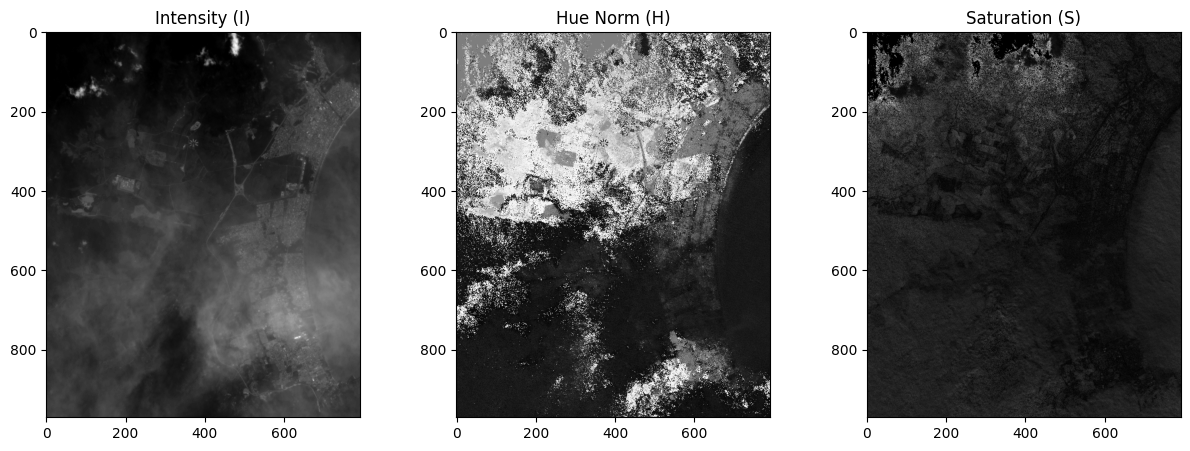

In [ ]:
# Transformação RGB-IHS
# Transformação RGB-IHS (IHS é uma transformação linear)
# Para converter para Intensity, Hue, Saturation, utilizamos as seguintes fórmulas:
I = (red_band + green_band + blue_band) / 3.0
H = 0.5 * np.arctan2(np.sqrt(3) * (green_band - blue_band), 2 * red_band - green_band - blue_band)

# Calcular a componente de saturação com tratamento de valores inválidos (NaN)
num = 2 * (red_band - green_band) ** 2 + (red_band - blue_band) * (green_band - blue_band)
den = red_band ** 2 + green_band ** 2 + blue_band ** 2 + 1e-8  # Adicionando uma pequena constante para evitar divisão por zero

# Usar np.clip para garantir que os valores do numerador e denominador estejam dentro de faixas adequadas
num = np.clip(num, 0, np.inf)
den = np.clip(den, 1e-8, np.inf)

S = np.sqrt(num / den)

# Normalizar os valores para o intervalo [0, 1]
I_norm = (I - np.min(I)) / (np.max(I) - np.min(I))
H_norm = (H - np.min(H)) / (np.max(H) - np.min(H))
S_norm = (S - np.min(S)) / (np.max(S) - np.min(S))

# Ajustar a componente de saturação para o intervalo [0, 255]
S_norm *= 255

# Juntar as bandas transformadas I, H e S novamente em um único array
bandas_ihs = np.stack([I_norm, H_norm, S_norm], axis=0)

# Visualizar as bandas transformadas I, H e S
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(I_norm, cmap='gray')
axes[0].set_title('Intensity (I)')
axes[1].imshow(H_norm, cmap='gray')
axes[1].set_title('Hue Norm (H)')
axes[2].imshow(S_norm, cmap='gray')
axes[2].set_title('Saturation (S)')
plt.show()

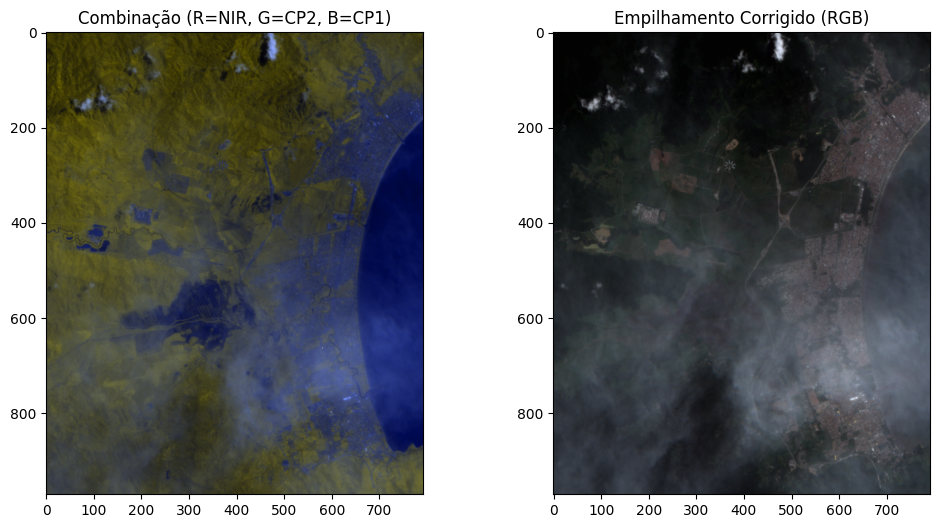

In [ ]:
#COMBINAÇÃO DOS ATRIBUTOS

# Normalizar a terceira componente principal (PC3) para o intervalo [0, 1]
pc1_norm = (bandas_pca[0] - np.min(bandas_pca[0])) / (np.max(bandas_pca[0]) - np.min(bandas_pca[0]))
pc2_norm = (bandas_pca[1] - np.min(bandas_pca[1])) / (np.max(bandas_pca[1]) - np.min(bandas_pca[1]))
pc3_norm = (bandas_pca[2] - np.min(bandas_pca[2])) / (np.max(bandas_pca[2]) - np.min(bandas_pca[2]))
pc4_norm = (bandas_pca[3] - np.min(bandas_pca[3])) / (np.max(bandas_pca[3]) - np.min(bandas_pca[3]))

# Ajustar a banda nir e os índices para o intervalo [0, 1]
nir_norm = (nir_band - np.min(nir_band)) / (np.max(nir_band) - np.min(nir_band))
ndwi_norm = (ndwi - np.min(ndwi)) / (np.max(ndwi) - np.min(ndwi))
savi_norm = (savi - np.min(savi)) / (np.max(savi) - np.min(savi))
evi_norm = (evi - np.min(evi)) / (np.max(evi) - np.min(evi))

# Combinação no espaço de cores RGB
R = nir_norm
G = pc2_norm
B = pc1_norm

# Empilhar as componentes em um único array RGB
rgb_combined = np.stack([R, G, B], axis=-1)

rgb_bands_corrigidas = np.moveaxis(stack_WPM[[2, 1, 0]], 0, -1)
rgb_bands_corrigidas_norm = rgb_bands_corrigidas / np.max(rgb_bands_corrigidas)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(rgb_combined)
axes[0].set_title('Combinação (R=NIR, G=CP2, B=CP1)')
axes[1].imshow(rgb_bands_corrigidas_norm)
axes[1].set_title('Empilhamento Corrigido (RGB)')
plt.show()

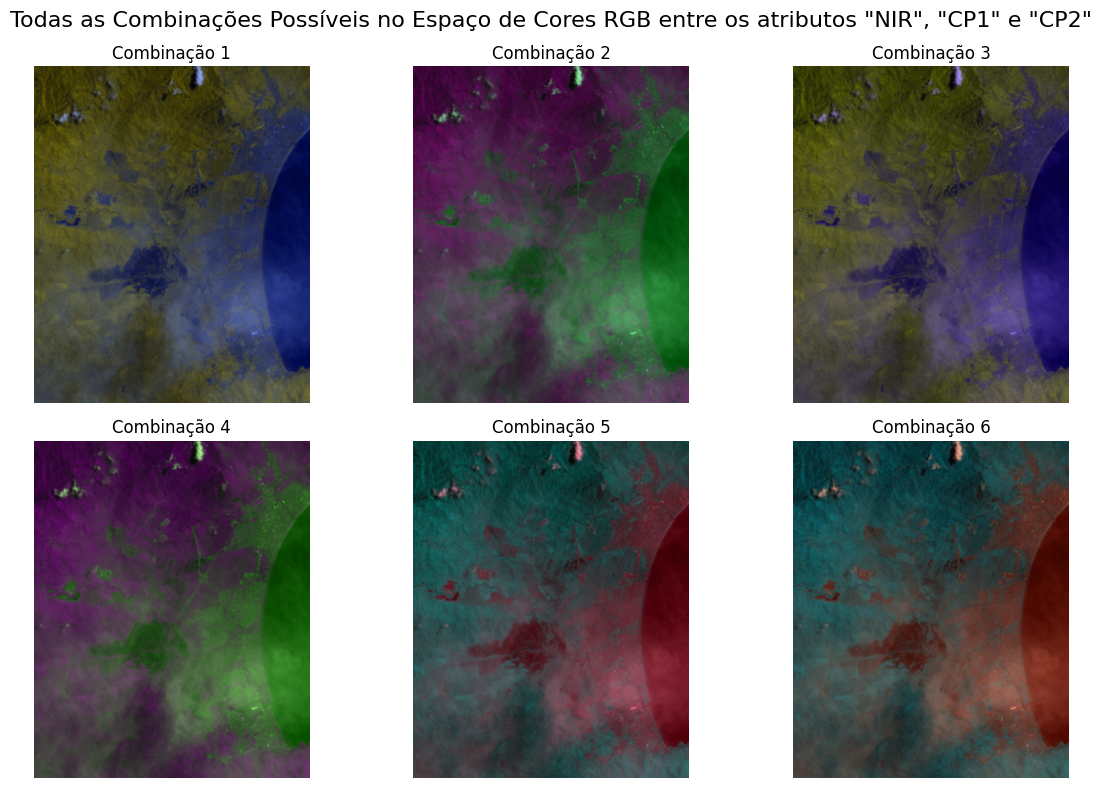

In [ ]:
# Criar todas as combinações possíveis das três bandas acima escolhidas
combinations = [(R, G, B), (R, B, G),(G, R, B),(G, B, R),(B, R, G),(B, G, R)]

# Configurar a figura para exibir as combinações
plt.figure(figsize=(12, 8))
plt.suptitle('Todas as Combinações Possíveis no Espaço de Cores RGB entre os atributos "NIR", "CP1" e "CP2"', fontsize=16)

# Exibir cada combinação em uma grade
for i, combination in enumerate(combinations):
    rgb_combined = np.stack(combination, axis=-1)

    plt.subplot(2, 3, i + 1)
    plt.imshow(rgb_combined)
    plt.title(f'Combinação {i + 1}')
    plt.axis('off')

# Ajustar o layout e exibir a figura
plt.tight_layout()
plt.show()

In [ ]:
# Gravação da imagem corrigida em disco
#with rio.open('sao_sebastiao_corrigida_brenda.tiff', 'w', **meta) as src:
  #src.write(stack_WPM)